##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with TensorFlow Lite Model Maker

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/models/modify/model_maker/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/models/modify/model_maker/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

The [TensorFlow Lite Model Maker library](https://www.tensorflow.org/lite/models/modify/model_maker) simplifies the process of adapting and converting a TensorFlow model to particular input data when deploying this model for on-device ML applications.

This notebook shows an end-to-end example that utilizes the Model Maker library to illustrate the adaptation and conversion of a commonly-used text classification model to classify movie reviews on a mobile device. The text classification model classifies text into predefined categories. The inputs should be preprocessed text and the outputs are the probabilities of the categories. The dataset used in this tutorial are positive and negative movie reviews.

## Prerequisites


### Install the required packages
To run this example, install the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

In [2]:
!sudo apt -y install libportaudio2
!pip install -q tflite-model-maker-nightly

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 1s (55.2 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

Import the required packages.

In [3]:
import numpy as np
import os

from tflite_model_maker import model_spec
from tflite_model_maker import text_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.text_classifier import AverageWordVecSpec
from tflite_model_maker.text_classifier import DataLoader

import tensorflow as tf
assert tf.__version__.startswith('2')
tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


### Download the sample training data.

In this tutorial, we will use the [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank) which is one of the tasks in the [GLUE](https://gluebenchmark.com/) benchmark. It contains 67,349 movie reviews for training and 872 movie reviews for testing. The dataset has two classes: positive and negative movie reviews.

In [ ]:
## No ejecutar
data_dir = tf.keras.utils.get_file(
      fname='SST-2.zip',
      origin='https://dl.fbaipublicfiles.com/glue/data/SST-2.zip',
      extract=True)
data_dir = os.path.join(os.path.dirname(data_dir), 'SST-2')

7454720/7439277 [==============================] - 2s 0us/step


The SST-2 dataset is stored in TSV format. The only difference between TSV and CSV is that TSV uses a tab `\t` character as its delimiter instead of a comma `,` in the CSV format.

Here are the first 5 lines of the training dataset. label=0 means negative, label=1 means positive.

| sentence                                                                                  | label |   |   |   |
|-------------------------------------------------------------------------------------------|-------|---|---|---|
| hide new secretions from the parental units                                               | 0     |   |   |   |
| contains no wit , only labored gags                                                       | 0     |   |   |   |
| that loves its characters and communicates something rather beautiful about human nature  | 1     |   |   |   |
| remains utterly satisfied to remain the same throughout                                   | 0     |   |   |   |
| on the worst revenge-of-the-nerds clichés the filmmakers could dredge up                  | 0     |   |   |   |

Next, we will load the dataset into a Pandas dataframe and change the current label names (`0` and `1`) to a more human-readable ones (`negative` and `positive`) and use them for model training.



In [1]:
## No ejecutar

import pandas as pd

def replace_label(original_file, new_file):
  # Load the original file to pandas. We need to specify the separator as
  # '\t' as the training data is stored in TSV format
  df = pd.read_csv(original_file, sep='\t')

  # Define how we want to change the label name
  label_map = {0: 'negative', 1: 'positive'}

  # Excute the label change
  df.replace({'label': label_map}, inplace=True)

  # Write the updated dataset to a new file
  df.to_csv(new_file)

# Replace the label name for both the training and test dataset. Then write the
# updated CSV dataset to the current folder.
replace_label(os.path.join(os.path.join(data_dir, 'train.tsv')), 'train.csv')
replace_label(os.path.join(os.path.join(data_dir, 'dev.tsv')), 'dev.csv')

NameError: ignored

### Custom Dataset
https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset/code?select=Reddit_Data.csv
- Twitter Dataset
- Reddit Dataset 

### Dataset Reddit

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [16]:
reddit_data = pd.read_csv('/content/Reddit_Data.csv')
twitter_data = pd.read_csv('/content/Twitter_Data.csv')

In [17]:
reddit_data.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [19]:
def replace_label(original_file, new_file):
  reddit_data = pd.read_csv('/content/Reddit_Data.csv')

  reddit_data = reddit_data.rename(columns={'text': 'clean_text', 'sentiment':'category'})
  reddit_data['category'] = reddit_data['category'].map({-1: 'Positive', 0: 'Negative', 1: 'Neutro'})

  reddit_data.to_csv(new_file)

replace_label(os.path.join(os.path.join('Reddit_Data')), 'train.csv')

In [20]:
reddit_data_1 = pd.read_csv('/content/train.csv')

In [28]:
reddit_data_1.head()

,Unnamed: 0,clean_comment,category
0,0,family mormon have never tried explain them t...,Neutro
1,1,buddhism has very much lot compatible with chr...,Neutro
2,2,seriously don say thing first all they won get...,Positive
3,3,what you have learned yours and only yours wha...,Negative
4,4,for your own benefit you may want read living ...,Neutro


### Dataset Reddit and Twitter


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

In [5]:
reddit_data = pd.read_csv('/content/Reddit_Data.csv')
twitter_data = pd.read_csv('/content/Twitter_Data.csv')

In [6]:
def cleanText(string):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    cleanedText = ' '.join(''.join([i for i in string if not i.isdigit()]).split())
    
    for i in punc:
        cleanedText = cleanedText.replace(i, '')
        
    a = [i for i in cleanedText if i.isalpha() or i == ' ']
            
    final_text = ' '.join(''.join(a).split())
    return final_text

### Cleaning Data

In [7]:
reddit_data = reddit_data.dropna(how='any')
twitter_data = twitter_data.dropna(how='any')

In [8]:
reddit_data.rename(columns={'clean_comment':'comment'}, inplace=True)
twitter_data.rename(columns={'clean_text':'comment'}, inplace=True)

In [9]:
reddit_data.category = reddit_data.category.apply(lambda x: int(x))
twitter_data.category = twitter_data.category.apply(lambda x: int(x))

In [10]:
reddit_data.comment = reddit_data.comment.apply(cleanText)
twitter_data.comment = twitter_data.comment.apply(cleanText)

In [11]:
reddit_data.drop_duplicates(subset='comment', keep=False, inplace=True)
twitter_data.drop_duplicates(subset='comment', keep=False, inplace=True)

In [12]:
concat_df = pd.concat([reddit_data, twitter_data], ignore_index=True)
concat_df.drop_duplicates(subset='comment', keep=False, inplace=True)

### Data Vitualization

In [13]:
counts = [len(reddit_data), len(twitter_data), len(concat_df)]
labels = ['Reddit', 'Twitter', 'Total']
colors = ['#ff4500', '#1DA1F2', '#50C878']

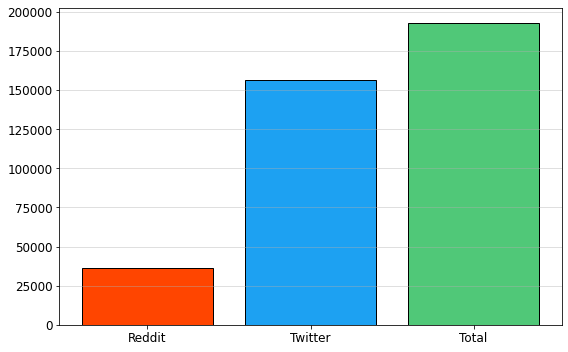

In [14]:
plt.figure(figsize=(8,5))

plt.bar(labels, counts, color=colors, edgecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

In [17]:
negative_count = [len(reddit_data[reddit_data.category == -1]),
                 len(twitter_data[twitter_data.category == -1]),
                 len(concat_df[concat_df.category == -1])]

neutral_count = [len(reddit_data[reddit_data.category == 0]),
                 len(twitter_data[twitter_data.category == 0]),
                 len(concat_df[concat_df.category == 0])]

positive_count = [len(reddit_data[reddit_data.category == 1]),
                 len(twitter_data[twitter_data.category == 1]),
                 len(concat_df[concat_df.category == 1])]

x = ['Reddit', 'Twitter', 'Total']
x_indexes = np.arange(len(x))
width = 0.25

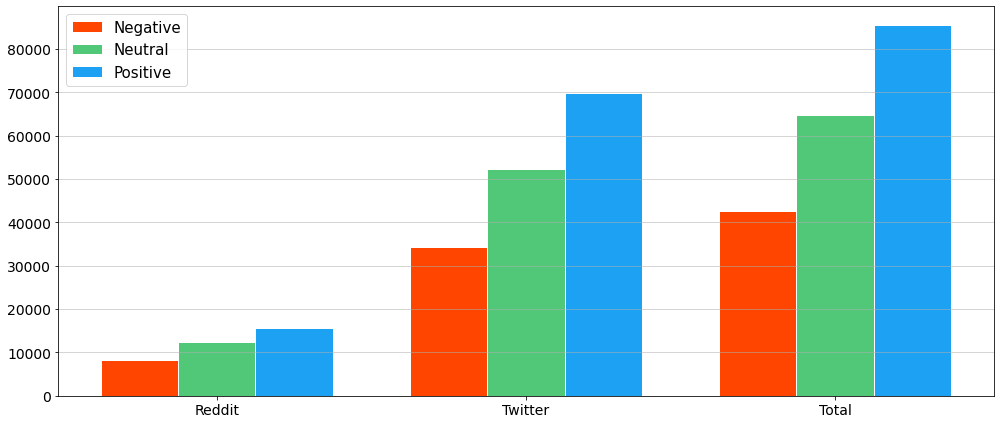

In [18]:
plt.figure(figsize=(14,6))

plt.bar(x_indexes - width, negative_count, width=width, label='Negative', edgecolor='white', color='#ff4500')
plt.bar(x_indexes, neutral_count, width=width, label='Neutral', edgecolor='white', color='#50C878')
plt.bar(x_indexes + width, positive_count, width=width, label='Positive', edgecolor='white', color='#1DA1F2')

plt.yticks(fontsize=14)
plt.xticks(ticks=x_indexes, labels=x, fontsize=14)

plt.legend(prop={'size':15})
plt.grid(axis='y', alpha=0.65)
plt.tight_layout()

In [19]:
negative_avg = int(sum([len(i) for i in concat_df[concat_df.category == -1].comment]) / len(concat_df[concat_df.category == 1]))
neutral_avg = int(sum([len(i) for i in concat_df[concat_df.category == 0].comment]) / len(concat_df[concat_df.category == 0]))
positive_avg = int(sum([len(i) for i in concat_df[concat_df.category == 1].comment]) / len(concat_df[concat_df.category == 1]))

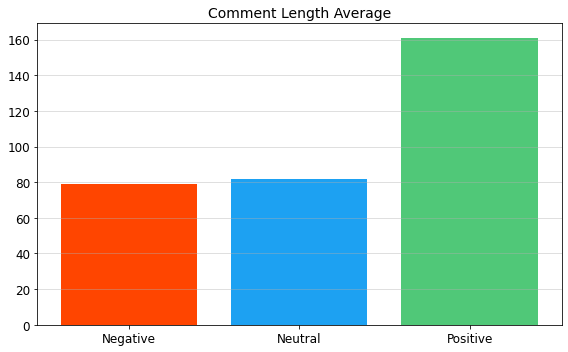

In [20]:
plt.figure(figsize=(8,5))

plt.bar(['Negative', 'Neutral', 'Positive'], [negative_avg, neutral_avg, positive_avg], color=colors)

plt.title('Comment Length Average', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

### Balance the Data 

In [21]:
class Data:
    def __init__(self, df):
        self.df = df
        
    def fixData(self):
        dataframe = self.df
        lowest_len = min([i for i in dataframe.category.value_counts()])
        
        # Create the final data frame
        final_df = pd.concat([dataframe[dataframe.category == -1][:lowest_len],
                             dataframe[dataframe.category == 0][:lowest_len],
                             dataframe[dataframe.category == 1][:lowest_len]])
        
        # To shuffle the rows in the data frame
        final_df = final_df.sample(frac=1).reset_index(drop=True)
        return final_df

In [22]:
a = Data(concat_df)
fixed_df = a.fixData()
print(f'Before: \n{concat_df.category.value_counts()}\n')
print(f'After: \n{fixed_df.category.value_counts()}')

Before: 
 1    85581
 0    64771
-1    42628
Name: category, dtype: int64

After: 
 0    42628
-1    42628
 1    42628
Name: category, dtype: int64


In [24]:
fixed_df.size

255768

In [25]:
concat_df.size

385960

### Dowload the csv file

In [26]:
fixed_df.to_csv('dataset.csv')

In [27]:
main_dataset = pd.read_csv('/content/dataset.csv')

In [29]:
main_dataset.head(10)

,Unnamed: 0,comment,category
0,0,still pakistan someone from mea belt this guy ...,0
1,1,sir include demands ews students and upsc csat...,0
2,2,who are these people film makers maybe their m...,-1
3,3,our next will modi,0
4,4,lakh reward for beheading mamata banerjee says...,-1
5,5,bjp karyakartha shri vijay has developed mobil...,-1
6,6,modi coming live address the media have money ...,1
7,7,the author poet and professor jnu views expres...,1
8,8,isnt third rate politics,0
9,9,indias agricultural growth gathers new momentu...,1


### Edit the main dataset

In [31]:
def replace_label(original_file, new_file):
  reddit_data = pd.read_csv('/content/dataset.csv')

  reddit_data = reddit_data.rename(columns={'text': 'comment', 'category':'category'})
  reddit_data['category'] = reddit_data['category'].map({-1: 'Negative', 0: 'Neutral', 1: 'Positive'})

  reddit_data.to_csv(new_file)

replace_label(os.path.join(os.path.join('Reddit_Data')), 'train_1.csv')

In [5]:
dataset_complete = pd.read_csv('/content/train_1.csv')

In [6]:
dataset_complete.head()

,Unnamed: 0,Unnamed: 0.1,comment,category
0,0,0,still pakistan someone from mea belt this guy ...,Neutral
1,1,1,sir include demands ews students and upsc csat...,Neutral
2,2,2,who are these people film makers maybe their m...,Negative
3,3,3,our next will modi,Neutral
4,4,4,lakh reward for beheading mamata banerjee says...,Negative


In [7]:
dataset_complete.size

511536

## Quickstart

There are five steps to train a text classification model:

**Step 1. Choose a text classification model architecture.**

Here we use the average word embedding model architecture, which will produce a small and fast model with decent accuracy.

## Choose a model architecture for Text Classifier

Each `model_spec` object represents a specific model for the text classifier. TensorFlow Lite Model Maker currently supports [MobileBERT](https://arxiv.org/pdf/2004.02984.pdf), averaging word embeddings and [BERT-Base](https://arxiv.org/pdf/1810.04805.pdf) models.

| Supported Model          | Name of model_spec      | Model Description                                                                                                     | Model size                                  |
|--------------------------|-------------------------|-----------------------------------------------------------------------------------------------------------------------|---------------------------------------------|
| Averaging Word Embedding | 'average_word_vec'      | Averaging text word embeddings with RELU activation.                                                                  |           <1MB                             |
| MobileBERT               | 'mobilebert_classifier' | 4.3x smaller and 5.5x faster than BERT-Base while achieving competitive results, suitable for on-device applications. | 25MB w/ quantization <br/> 100MB w/o quantization                                        |
| BERT-Base                | 'bert_classifier'       | Standard BERT model that is widely used in NLP tasks.                                                                 | 300MB |

In the quick start, we have used the average word embedding model. Let's switch to [MobileBERT](https://arxiv.org/pdf/2004.02984.pdf) to train a model with higher accuracy.

In [8]:
spec = model_spec.get('mobilebert_classifier')

Model Maker also supports other model architectures such as [BERT](https://arxiv.org/abs/1810.04805). If you are interested to learn about other architecture, see the [Choose a model architecture for Text Classifier](#scrollTo=kJ_B8fMDOhMR) section below.

**Step 2.   Load the training and test data, then preprocess them according to a specific `model_spec`.**

Model Maker can take input data in the CSV format. We will load the training and test dataset with the human-readable label name that were created earlier.

Each model architecture requires input data to be processed in a particular way. `DataLoader` reads the requirement from `model_spec` and automatically executes the necessary preprocessing.

In [ ]:
# No ejecutar
train_data = DataLoader.from_csv(
      filename='train.csv',
      text_column='sentence',
      label_column='label',
      model_spec=spec,
      is_training=True)
test_data = DataLoader.from_csv(
      filename='dev.csv',
      text_column='sentence',
      label_column='label',
      model_spec=spec,
      is_training=False)

In [9]:
# Ejecutar este codigo
data = DataLoader.from_csv(
      filename='train_1.csv',
      text_column='comment',
      label_column='category',
      model_spec=spec,
      shuffle=True,
      is_training=True)
train_data, test_data = data.split(0.9)

**Step 3. Train the TensorFlow model with the training data.**

The average word embedding model use `batch_size = 32` by default. Therefore you will see that it takes 2104 steps to go through the 67,349 sentences in the training dataset. We will train the model for 10 epochs, which means going through the training dataset 10 times.

In [10]:
model = text_classifier.create(train_data, model_spec=spec, epochs=3, validation_data=test_data)

2397/2397 [==============================] - 1102s 437ms/step - loss: 0.6395 - test_accuracy: 0.7831 - val_loss: 0.1857 - val_test_accuracy: 0.9406
Epoch 2/2
2397/2397 [==============================] - 1043s 434ms/step - loss: 0.1375 - test_accuracy: 0.9582 - val_loss: 0.1379 - val_test_accuracy: 0.9589
Epoch 3/3
2397/2397 [==============================] - 1045s 435ms/step - loss: 0.0811 - test_accuracy: 0.9771 - val_loss: 0.1361 - val_test_accuracy: 0.9633


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 hub_keras_layer_v1v2 (HubKeras  (None, 512)         24581888    ['input_word_ids[0][0]',         
 LayerV1V2)                                                       'input_mask[0][0]',         

**Step 4. Evaluate the model with the test data.**

After training the text classification model using the sentences in the training dataset, we will use the remaining 872 sentences in the test dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 32, it will take 28 steps to go through the 872 sentences in the test dataset.

In [12]:
loss, acc = model.evaluate(test_data)

400/400 [==============================] - 50s 114ms/step - loss: 0.1361 - test_accuracy: 0.9633


## Export as a TensorFlow Lite model

Convert the trained model to TensorFlow Lite model format with [metadata](https://www.tensorflow.org/lite/models/convert/metadata) so that you can later use in an on-device ML application. The label file and the vocab file are embedded in metadata. The default TFLite filename is `model.tflite`.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you apply quantize the model to make it smaller and potentially run faster.
The default post-training quantization technique is dynamic range quantization for the BERT and MobileBERT models.

In [35]:
model.export(export_dir='mobilebert_redit/')

In [ ]:
model.export(export_dir='mobilebert_redit/')

You can download the TensorFlow Lite model file using the left sidebar of Colab. Go into the `average_word_vec` folder as we specified in `export_dir` parameter above, right-click on the `model.tflite` file and choose `Download` to download it to your local computer.

This model can be integrated into an Android or an iOS app using the [NLClassifier API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/nl_classifier) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview).

See the [TFLite Text Classification sample app](https://github.com/tensorflow/examples/blob/master/lite/examples/text_classification/android/lib_task_api/src/main/java/org/tensorflow/lite/examples/textclassification/client/TextClassificationClient.java#L54) for more details on how the model is used in a working app.

*Note 1: Android Studio Model Binding does not support text classification yet so please use the TensorFlow Lite Task Library.*

*Note 2: There is a `model.json` file in the same folder with the TFLite model. It contains the JSON representation of the [metadata](https://www.tensorflow.org/lite/models/convert/metadata) bundled inside the TensorFlow Lite model. Model metadata helps the TFLite Task Library know what the model does and how to pre-process/post-process data for the model. You don't need to download the `model.json` file as it is only for informational purpose and its content is already inside the TFLite file.*

*Note 3: If you train a text classification model using MobileBERT or BERT-Base architecture, you will need to use [BertNLClassifier API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/bert_nl_classifier) instead to integrate the trained model into a mobile app.*

In [ ]:
model.export(export_dir='mobilebert/')

In [13]:
model.export(export_dir='mobilebert_twitter_reddit/')

The TensorFlow Lite model file can be integrated in a mobile app using the [BertNLClassifier API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/bert_nl_classifier) in [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview). Please note that this is **different** from the `NLClassifier` API used to integrate the text classification trained with the average word vector model architecture.

The export formats can be one or a list of the following:

*   `ExportFormat.TFLITE`
*   `ExportFormat.LABEL`
*   `ExportFormat.VOCAB`
*   `ExportFormat.SAVED_MODEL`

By default, it exports only the TensorFlow Lite model file containing the model metadata. You can also choose to export other files related to the model for better examination. For instance, exporting only the label file and vocab file as follows:

In [ ]:
model.export(export_dir='mobilebert/', export_format=[ExportFormat.LABEL, ExportFormat.VOCAB, ExportFormat.SAVED_MODEL])

You can evaluate the TFLite model with `evaluate_tflite` method to measure its accuracy. Converting the trained TensorFlow model to TFLite format and apply quantization can affect its accuracy so it is recommended to evaluate the TFLite model accuracy before deployment.

In [ ]:
accuracy = model.evaluate_tflite('mobilebert_twitter_reddit/model.tflite', test_data)
print('TFLite model accuracy: ', accuracy)

### Customize Post-training quantization on the TensorFlow Lite model

[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.

Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

```python
config = QuantizationConfig.for_float16()
```


Then we export the TensorFlow Lite model with such configuration.

```python
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)
```

## Dowload the pretrained model

In [53]:
!cp mobile_bert/model.tflite sentiment_analysis.tflite

from google.colab import files
files.download('model.tflite') 

cp: cannot stat 'mobile_bert/model.tflite': No such file or directory


FileNotFoundError: ignored

## Ruta de Andriod Studio para pegar el modelo preentrenado

C:\Users\HOME\Documents\GitHub\sentiment_analysis_example\lite\examples\text_classification\android\app\src\androidTest\assets

# Read more

You can read our [text classification](https://www.tensorflow.org/lite/examples/text_classification/overview) example to learn technical details. For more information, please refer to:

*   TensorFlow Lite Model Maker [guide](https://www.tensorflow.org/lite/models/modify/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).
*  Task Library: [NLClassifier](https://www.tensorflow.org/lite/inference_with_metadata/task_library/nl_classifier) and [BertNLClassifier](https://www.tensorflow.org/lite/inference_with_metadata/task_library/bert_nl_classifier) for deployment.
*   The end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/text_classification/android) and [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/text_classification/ios).